Simulation of AD model from:

Dynamical Adaptation in Photoreceptors
Damon A. Clark,Raphael Benichou,Markus Meister,Rava Azeredo da Silveira 
Published: November 14, 2013https://doi.org/10.1371/journal.pcbi.1003289
parameters are from here

Also, feedback from Drinnenberg's paper

s - stimulation   r - response



In [58]:
import numpy as np
from random import gauss
from math import sqrt
import matplotlib as mpl
mpl.use('nbagg')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
def fac(n):
    value =1 
    for i in range(1,int(n+1)):
        value = value*i
    return(int(value))

def bf(t,tau,n):
    nf = fac(n)
    return(np.exp(-t/tau)*t**int(n)/nf/tau**(n+1))

def Ky(t,tau_y,n_y):
    return(bf(t,tau_y,n_y))

def Kz(t,gamma,tau_y,n_y,tau_z,n_z):
    A = bf(t,tau_y,n_y)
    B = bf(t,tau_z,n_z)
    return(gamma*A + (1-gamma)*B)

In [60]:
def rescale(x,xmax,xmin):
    rx = np.zeros(len(x))
    xminval = np.min(x)
    xmaxval = np.max(x)
    for i in range(len(x)):
        rx[i] = (x[i]-xminval)/(xmaxval-xminval)*(xmax-xmin)+xmin
    return rx
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [61]:
n_y = 2
n_z = 3
tau_y = 50
tau_z = 60
gamma = 0.5

0.9999999993333545 0.9999992439288232


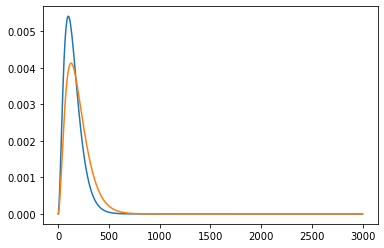

In [62]:
# shapes of the kernel
klen = 3001 # kernel length
t = np.arange(klen)

# generate the time series for the kernels
# will be used for computation of convolution with signal

kyts = Ky(t,tau_y,n_y)
kzts = Kz(t,gamma,tau_y,n_y,tau_z,n_z)
plt.plot(kyts)
plt.plot(kzts)
print(np.sum(kyts),np.sum(kzts))

In [63]:
# generate the HMM signal to be sued as input
from random import gauss
G_HMM = 3; 
D_HMM = 2.7e6;     #dynamical range
nstep = 10000*5*2
dt = 0.001  # 1msec time step

# HMM model parameters
#    G_HMM = 5; 
#    D_HMM = 2700000;     #dynamical range
omega =G_HMM/2.12;   # omega = G/(2w)=1.06; follow Bialek's overdamped dynamics/ 2015PNAS

# generate the stochastic sequence in x
x = np.zeros(nstep)
v = np.zeros(nstep)
x[0] = 0.0
v[0] = 0.0
for i in range(1,nstep):
        x[i] = x[i-1] + v[i-1]*dt
        v[i] = (1-G_HMM*dt)*v[i-1]-omega**2*x[i-1]*dt + gauss(0,1)*np.sqrt(D_HMM*dt)
ss = rescale(x,1,-1) # rescale the data into [-1,1]
s = ss[klen-1:]      # becaues of convolution in numpy, we need to remove 
                     # the first klen points from the signal when compared with convoluted signal

(0.0, 10000.0)

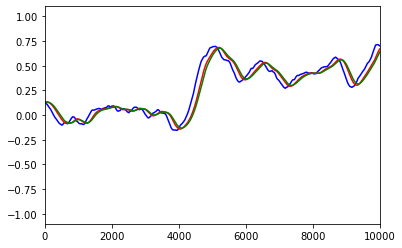

In [64]:
# s is the signal with the first klen points removed
# but we need to use original signal ss for convolution

y = np.convolve(ss,kyts,'valid')
z = np.convolve(ss,kzts,'valid')

plt.plot(s,'b')
plt.plot(y,'r')
plt.plot(z,'g')
plt.xlim([0,10000])

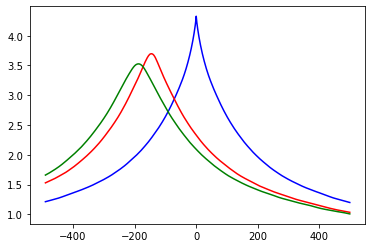

In [65]:
# compute time lag mutual information
# to show that both y and z are lag behind s
dms = range(-490,500)
mi_ss = [mi_quick(s,s,d) for d in dms]  
mi_sy = [mi_quick(s,y,d) for d in dms]
mi_sz = [mi_quick(s,z,d) for d in dms]
plt.plot(dms,mi_ss,'b')
plt.plot(dms,mi_sy,'r')
plt.plot(dms,mi_sz,'g')

In [66]:
# Main loop starts here after ss, z and y are generated
# ss, z and y are all evaluated at 1msec 
# dt =1 means we are integrating with dt = 1

dt = 1
nstep = len(y)
alpha = 1
beta = 0.2
tau_r = 30
r = np.zeros(nstep)
for i in range(1,nstep-1):
    dr = (alpha*y[i] - (1 + beta*z[i])*r[i])*dt/tau_r
    r[i+1] = r[i] + dr

(40000.0, 60000.0)

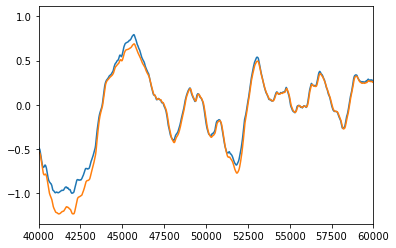

In [78]:
plt.plot(s)
plt.plot(r)
plt.xlim(40000,60000)

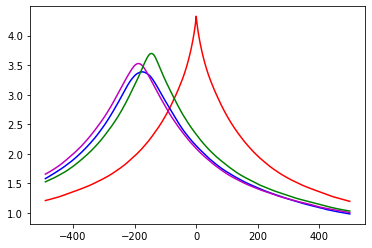

In [68]:
# compute time lag mutual information
# to show that both y and z are lag behind s
dms = range(-490,500)
mi_ss = [mi_quick(s,s,d) for d in dms]  
mi_sr= [mi_quick(s,r,d) for d in dms]

plt.plot(dms,mi_ss,'r')
plt.plot(dms,mi_sr,'b')
plt.plot(dms,mi_sz,'m')
plt.plot(dms,mi_sy,'g')

# conclusoin:
# with just dynamical adapation (DA), there is no anticipation
# basically the delay in repsonse is due to the delay in z

In [69]:
def Kh(t,tau_h):
    return(np.exp(-t/tau_h)*t/tau_h/tau_h)

In [70]:
tau_h = 317
alpha_h = 0.792
khts = Kh(t,tau_h)

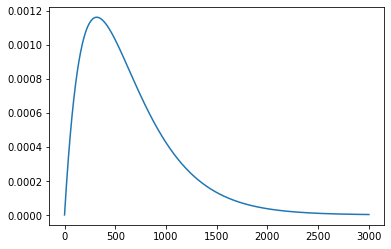

In [71]:
plt.plot(khts)

# with feedback phi = 1.0

In [72]:
# with feedback from h, phi = 1.0
# solving eqn from Drinenberg
tau_h = 317
alpha_h = 0.792
dt = 1
nstep = len(y)
alpha = 1
beta = 0.2
tau_r = 30

phi = 1.0

r = np.zeros(nstep)
h = np.zeros(nstep)
for i in range(1,nstep):
    dr = (alpha*s[i-1] - (1 + beta*z[i-1])*(r[i-1] + phi*h[i-1]))*dt/tau_r
    dh = (alpha_h*r[i-1] - h[i-1])*dt/tau_h
    r[i] = r[i-1] + dr
    h[i] = h[i-1] + dh

(0.0, 20000.0)

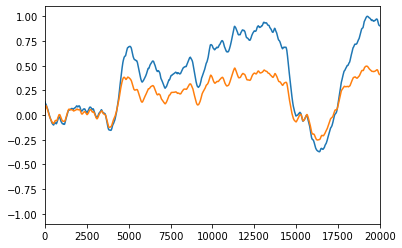

In [73]:
plt.plot(s)
plt.plot(r)
plt.xlim([0,20000])

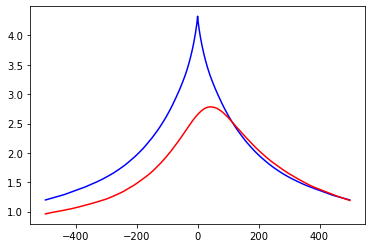

In [74]:
dms = range(-499,500)
mi_ss = [mi_quick(s,s,d) for d in dms]  
mi_sr = [mi_quick(s,r,d) for d in dms]

plt.plot(dms,mi_ss,'b')
plt.plot(dms,mi_sr,'r')

# no feedback phi = 0.0

In [75]:
# with feedback from h, phi = 0.0
tau_h = 317
alpha_h = 0.792
dt = 1
nstep = len(y)
alpha = 1
beta = 0.2
tau_r = 30

phi = 0.0

r = np.zeros(nstep)
h = np.zeros(nstep)
for i in range(1,nstep):
    dr = (alpha*s[i-1] - (1 + beta*z[i-1])*(r[i-1] + phi*h[i-1]))*dt/tau_r
    dh = (alpha_h*r[i-1] - h[i-1])*dt/tau_h
    r[i] = r[i-1] + dr
    h[i] = h[i-1] + dh

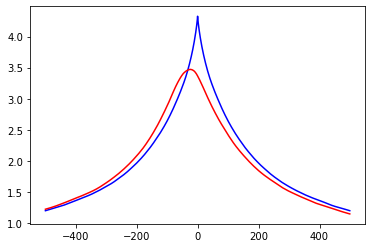

In [76]:
dms = range(-499,500)
mi_ss = [mi_quick(s,s,d) for d in dms]  
mi_sr = [mi_quick(s,r,d) for d in dms]

plt.plot(dms,mi_ss,'b')
plt.plot(dms,mi_sr,'r')